In [1]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import rebound
import datetime
from scipy import interpolate
from scipy.optimize import newton
%matplotlib inline

plt.rcParams['font.size'] = 21
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 14
plt.rcParams['ytick.major.size']  = 14
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 8
plt.rcParams['ytick.minor.size']  = 8
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'


# Load the simulation for the N body integrator with Oumuamua's trajectory

In [2]:
date = datetime.datetime(2010, 7, 9, 11, 4)
date=datetime.datetime(2000, 7, 9, 11, 4)
sim = rebound.Simulation()
sim.add("Sun", date=date)
sim.add("Earth", date=date)
sim.add("NAME=3788040", date=date)


Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Earth'... 
Found: Earth-Moon Barycenter (3) (chosen from query 'Earth')
Searching NASA Horizons for 'NAME=3788040'... 
Found: 1I/'Oumuamua (A/2017 U1) 


/opt/homebrew/anaconda3/lib/python3.9/site-packages/rebound/horizons.py:168: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


# Run the N body integrator and get trajectory

In [3]:
# integrate
Noutputs = 10000
Noutputs = 500000
year = 2.*np.pi # One year in units where G=1
times = np.linspace(0.,2.*17.*year, Noutputs)
x = np.zeros((2,Noutputs))
y = np.zeros((2,Noutputs))
z = np.zeros((2,Noutputs))

sim.integrator = "ias15" # IAS15 is the default integrator, so we actually don't need this line
sim.move_to_com()        # We always move to the center of momentum frame before an integration
ps = sim.particles       # ps is now an array of pointers and will change as the simulation runs


sim.dt = sim.particles[1].P/60. # small fraction of Mercury's period

for i,time in enumerate(times):
    sim.integrate(time)
    x[0][i] = ps[1].x   # This stores the data which allows us to plot it later
    y[0][i] = ps[1].y
    z[0][i] = ps[1].z
    x[1][i] = ps[2].x
    y[1][i] = ps[2].y
    z[1][i] = ps[2].z

# Convert to years units and get distance, interpolate distance function

In [4]:
timessec = times/(year)*3.154e7
distance=np.sqrt(x[1]**2+y[1]**2+z[1]**2)
f = interpolate.interp1d(timessec, distance)

In [19]:
np.savez('dist_time.npz', distance=distance, time=times)

# Define Functions to compute the thermal model evolution

In [5]:
def func(T,Ein,sigma,A,deltaT,kappa,Tf,Tf2,dx,rho,cp,Tlast,xf,x):
    return(Ein-T**4*sigma*A*deltaT-(cp*rho*dx*A)*(T-Tlast)-(kappa*(T-Tf)/(dx))*deltaT*.5*(xf+x)/x)
def midbc(T,Tf,Tlast,kappar,cp,rho,dxr,dxice,deltaT,kappaice,Tl,xf,x,xl):
    return(kappar*(Tf-T)*deltaT/dxr*.5*(xf+x)/xf-cp*rho*dxice*(T-Tlast)
           -kappaice*(T-Tl)*deltaT/dxice*.5*(xl+x)/xl)
def innerbc(T,Tf,kappaice,dxice,deltaT,cp,rho,Tlast,xo,x):
    return(kappaice*(Tf-T)*deltaT/dxice*.5*(xo+x)/x-cp*rho*dxice*(T-Tlast))

def thermal_model(kappagunk = 0.009/100.,rhogunk= 1.0,cpgunk = 0.55):
#constants
    date_peri = datetime.datetime(2017,9,9,11,4)
    Lsun = 3.848e26 # J/s
    AU=1.49597892e13 #// astron unit, cm 
    albedo=.1
    sigma = 5.6704e-8/100./100.*.95 # watts/cm^2 Kevlin^4 .95 is bolometric emmisivity

    Lx = 900 
    nx = 100

    dx=Lx/nx
    x_ar=np.zeros(nx)
    dxar=np.zeros(nx)

    for i in np.arange(nx):

        x_ar[i]=(i+1)*dx
        dxar[i]=dx
    A = 1.0 # 1 cm^2 area

    kappa = np.zeros_like(x_ar)
    rho = np.zeros_like(x_ar)
    cp = np.zeros_like(x_ar)
    print('dt reg',rhogunk*cpgunk/kappagunk*dx*dx)

    for i in np.arange(nx):
        kappa[i]=kappagunk
        rho[i]=rhogunk
        cp[i]=cpgunk

    T = 5.*np.ones_like(x_ar) # inital temperature profile - all 10
    E = T*cp*rho *dx *A
    Tp=np.zeros_like(x_ar)

    datestart= datetime.datetime(2011, 2, 9, 11, 4)
    date=datestart
    t=0.
    t=(datestart-datetime.datetime(2000, 7, 9, 11, 4)).total_seconds()
    dateend=datetime.datetime(2023, 12, 9, 11, 4)
    tstop = (dateend-datetime.datetime(2000, 7, 9, 11, 4)).total_seconds()
    cadence =3.154e7*1./1200.
    deltaT=300.
    deltaT=rhogunk*cpgunk/kappagunk*dx*dx/2.
    print(deltaT)

    T11 = np.zeros([nx,50000])
    E11= np.zeros([nx,50000])
    datelist=[]
    datelist.append(date)

    distance_list=[]
    distance_list.append(f(t))
    distance_list_mag=[]
    distance_list_mag.append(f(t)*-1)

    #print distance_list
    cnt=0
    Etot=[]
    Etot1=[]
    Eouter=[]
    Ebudg=[]
    efficiency = []
    stepper=0
    print(t)
    nxice=0
    while(t<tstop):
        stepper+=1
        flux =  .25*Lsun/(4.*np.pi*AU*AU*f(t+deltaT/2.)*f(t+deltaT/2.))*(1.-albedo)

        Ein = flux*deltaT
        Tlast = T[-1]
        E[-1]+=Ein
        T[-1]= E[-1]/(cp[-1]*rho[-1]*dx*A)
        if(cnt==0):
            Tguess = newton(func,40.,args=(Ein,sigma,A,deltaT,kappa[-1],T[-2],T[-3],dxar[-1],rho[-1],cp[-1],Tlast,x_ar[nx-1],x_ar[nx-2]))
        else:
            Tguess = newton(func,Tlast,args=(Ein,sigma,A,deltaT,kappagunk,T[-2],T[-3],dxar[-1],rhogunk,cpgunk,Tlast,x_ar[nx-1],x_ar[nx-2])#)
                            ,maxiter=400,tol=1.48e-02)
        Erad = Tguess**4*sigma*A*deltaT
        Edif = (kappagunk*(T[-3]-2.*T[-2]+Tguess)/(dxar[-1]))*deltaT
        Eout = Erad+Edif

        DeltaEin = (cp[-1]*rho[-1]*dx*A)*(Tguess-Tlast)
        Eouter.append(Ein-Erad-Edif-DeltaEin)
        E[-1]+=-Eout
        T[-1]=Tguess

        for i in np.arange(1,nx-1):
            #finite difference cylindrical cord
            d2Tdr= 1./(dxar[i])*1./x_ar[i]*(.5*(x_ar[i+1]+x_ar[i])/(x_ar[i+1]-x_ar[i])*(T[i+1]-T[i])
                                                 -.5*(x_ar[i-1]+x_ar[i])/(-x_ar[i-1]+x_ar[i])*(T[i]-T[i-1]))
            Tp[i] = kappa[i]/(rho[i]*cp[i])*deltaT*d2Tdr
        T[:]+=Tp[:]

        Tinner = 5

        DeltaEinnerBC = (Tinner-T[0])*(cp[0]*rho[0]*dxar[0]*A)*(x[0]+dxar[0]*.5)/900.   
        T[0]=Tinner
        DeltaE=(cp[0:nx-1:]*rho[0:nx-1:]*dxar[0:nx-1:]*A)*(Tp[0:nx-1:])*((x_ar[0:nx-1:]+.5*dxar[1::])/900.)
        E[0:nx]=T[0:nx]*(cp[0:nx]*rho[0:nx]*dxar[0:nx]*A)

        t+=deltaT
        date+=datetime.timedelta(seconds=deltaT)

        Etot.append(sum(E))
        Etot1.append(Ein-Erad)
        Ebudg.append((Ein-Erad-DeltaEin-DeltaEinnerBC-sum(DeltaE)))

        if (abs(t%cadence)<deltaT):
            T11[:,cnt]=T[:]
            E11[:,cnt]=E[:]
            cnt+=1
            datelist.append(date)
            distance_list.append(f(t+deltaT/2.))
            
            efficiency.append(Erad/Ein)
            if date<date_peri:
                distance_list_mag.append(f(t+deltaT/2.)*-1)
            else:
                distance_list_mag.append(f(t+deltaT/2.))

    tdays=np.zeros(len(datelist))
    date_peri = datetime.datetime(2017,9,9,11,4)
    date_peri2=datetime.datetime(2000, 7, 9, 11, 4)
    distancer=np.zeros(len(datelist))
    tmonths=np.zeros(len(datelist))
    distmag=np.zeros(len(datelist))
    for i in np.arange(len(datelist)):
        tdays[i]=(datelist[i]-date_peri).total_seconds()/(60.*60.*24.)
        ttot=(datelist[i]-date_peri2).total_seconds()/(year)
    
            
        if datelist[i]<date_peri:
            distmag[i]=f(ttot+deltaT/2.)*-1
        else:
            distmag[i]=f(ttot+deltaT/2.)
        try:
            distancer[i]=distance_list[i]
        except:

            pass
    return(T11,x_ar,tdays,datelist,distance_list,distance_list_mag)


# Run thermal  models

In [6]:
# kappa 1e-2
rho = 0.5  # g/cm^3
kappa= 0.01/100  # watts / K / m 
cp = 2.0  #J/g/K
T11_lo,x_ar_lo,tdays_lo,datelist_lo,dist_lo,distmag_lo = thermal_model(kappa,rho,cp)

# kappa 1e-1
kappa = 0.1/100  # watts / K / m 
T11_hi,x_ar_hi,tdays_hi,datelist_hi,dist_hi,distmag_hi = thermal_model(kappa,rho,cp)


dt reg 810000.0
405000.0
334108800.0
dt reg 81000.0
40500.0
334108800.0


# Make Plots

/var/folders/jq/tw5trh1543q7l6mmhf0tsjth0000gn/T/ipykernel_37842/1242527702.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Thermal_models.pdf', rasterize=True, bbox_inches='tight', dpi=300)
/var/folders/jq/tw5trh1543q7l6mmhf0tsjth0000gn/T/ipykernel_37842/1242527702.py:56: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('Thermal_models.pdf', rasterize=True, bbox_inches='tight', dpi=300)
/var/folders/jq/tw5trh1543q7l6mmhf0tsjth0000gn/T/ipykernel_37842/1242527702.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Thermal_models.pdf', rasterize=True, bbox_inches='tight', dpi=300)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes t

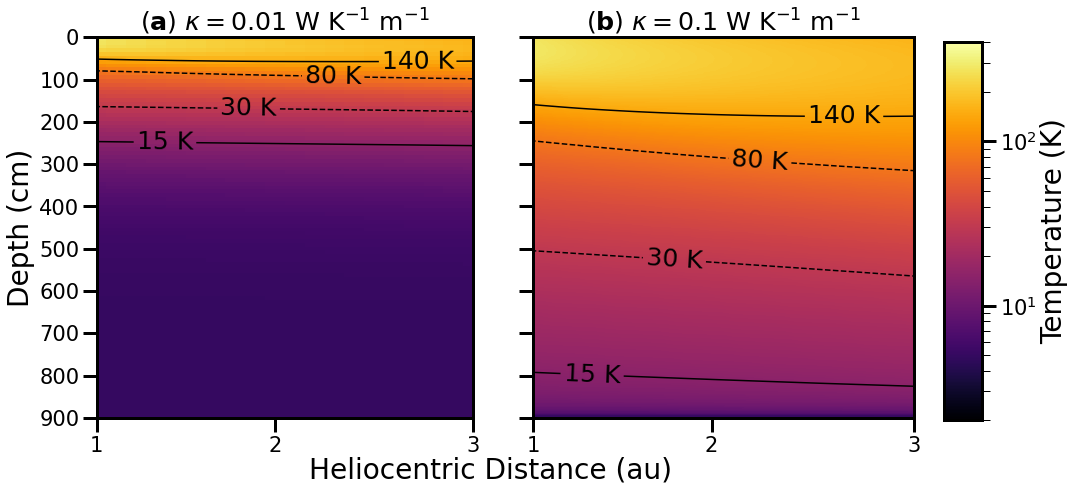

In [9]:
fig, axs = plt.subplots(1, 2, tight_layout=True,figsize=(15,7),sharex=False,sharey=True,
                       gridspec_kw={'hspace': 0.25, 'wspace': 0.1})

#################################
# First subplot: kappa 1e-2 ('lo')
im = axs[0].imshow(T11_lo[:,0:len(datelist_lo)], extent=[tdays_lo[0], tdays_lo[-1], 900, 0],
               origin='lower',aspect=.1,norm=colors.LogNorm(vmax=400.,vmin=2), cmap='inferno')
contours=axs[0].contour( T11_lo[:,0:len(datelist_lo)],levels=[15,30,80,140],extent=[tdays_lo[0], tdays_lo[-1], 900, 0],
                     alpha=0.99,colors='black',linestyles=['-','--','--','-'])

# x limit 1-3 au
indxmin=np.abs(np.array(distmag_lo) - 1.).argmin()
indxmax= np.abs(np.array(distmag_lo) - 3.).argmin()
indxmid=np.abs(np.array(distmag_lo) - 2.).argmin()
axs[0].set_xlim(tdays_lo[indxmin],tdays_lo[indxmax])
axs[0].set_xticks([tdays_lo[indxmin],tdays_lo[indxmid],tdays_lo[indxmax]])
axs[0].set_xticklabels([1,2,3])
axs[0].set_ylim(900,0)

fmt = {}
strs = ['15 K', '30 K', '80 K', '140 K']
for l, s in zip(contours.levels, strs):
    fmt[l] = s
manual_locations = [(40, 500), (60, 200),(80, 100),(100, 40)]
axs[0].clabel(contours,inline=True, fontsize=25, fmt=fmt, manual=manual_locations, colors=['black'])

##################################
# Second subplot: kappa 1e-1 ('hi')
im = axs[1].imshow(T11_hi[:,0:len(datelist_hi)], extent=[tdays_hi[0], tdays_hi[-1], 900, 0],
               origin='lower',aspect=.1,norm=colors.LogNorm(vmax=400.,vmin=2),cmap='inferno')
contours=axs[1].contour(T11_hi[:,0:len(datelist_hi)],levels=[15,30,80,140],extent=[tdays_hi[0], tdays_hi[-1], 900, 0],
                     alpha=0.99,colors='black',linestyles=['-','--','--','-'])

# x limit 1-3 au
indxmin_hi=np.abs(np.array(distmag_hi) - 1.).argmin()
indxmax_hi= np.abs(np.array(distmag_hi) - 3.).argmin()
indxmid_hi= np.abs(np.array(distmag_hi) - 2.).argmin()
axs[1].set_xlim(tdays_hi[indxmin_hi],tdays_hi[indxmax_hi])
axs[1].set_xticks([tdays_hi[indxmin_hi],tdays_hi[indxmid_hi],tdays_hi[indxmax_hi]])
axs[1].set_xticklabels([1,2,3])

manual_locations = [(40, 900), (60., 500),(80., 300),(100., 40)]
axs[1].clabel(contours,inline=True, fontsize=25, fmt=fmt, manual=manual_locations, colors=['black'])

##########
# Colorbar
cax = plt.axes([0.92, 0.12, 0.035, 0.75])
cbarr=fig.colorbar(im,cax=cax)
cbarr.set_label('Temperature (K)',fontsize=28)

###########################
axs[0].set_title(r'($\bf{a}$) $\kappa=0.01$ W K$^{-1}$ m$^{-1}$')
axs[1].set_title(r'($\bf{b}$) $\kappa=0.1$ W K$^{-1}$ m$^{-1}$')
axs[0].set_ylabel(r'Depth (cm)',fontsize=28)
fig.text(0.5, 0.02, 'Heliocentric Distance (au)', ha='center', va='center', rotation='horizontal',fontsize=28)

# plt.savefig('Thermal_models.pdf', rasterize=True, bbox_inches='tight', dpi=300)


/var/folders/jq/tw5trh1543q7l6mmhf0tsjth0000gn/T/ipykernel_37842/1109117129.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Thermal_prediction.pdf', rasterize=True, bbox_inches='tight', dpi=300)
/var/folders/jq/tw5trh1543q7l6mmhf0tsjth0000gn/T/ipykernel_37842/1109117129.py:68: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('Thermal_prediction.pdf', rasterize=True, bbox_inches='tight', dpi=300)
/var/folders/jq/tw5trh1543q7l6mmhf0tsjth0000gn/T/ipykernel_37842/1109117129.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Thermal_prediction.pdf', rasterize=True, bbox_inches='tight', dpi=300)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure inc

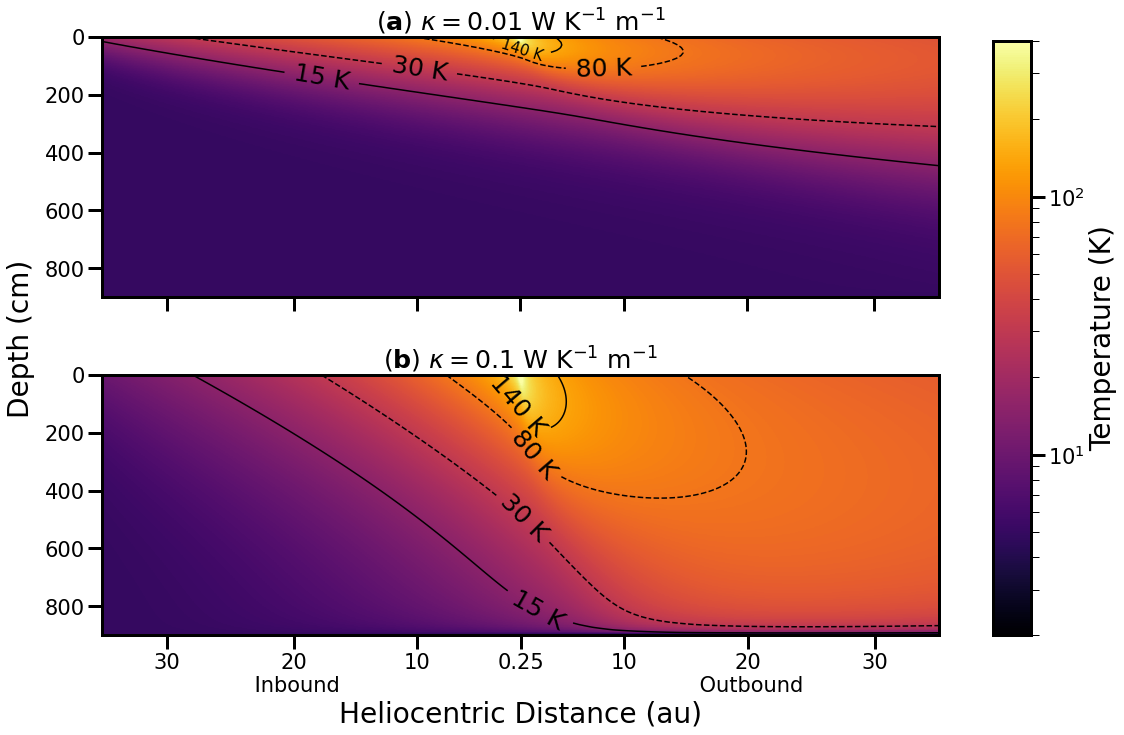

In [16]:
fig, axs = plt.subplots(2, 1, tight_layout=True,figsize=(15,11),sharex=False,sharey=True,
                       gridspec_kw={'hspace': 0.3, 'wspace': 0.1})

#################################
# First subplot: kappa 1e-2 ('lo')
im = axs[0].imshow(T11_lo[:,0:len(datelist_lo)], extent=[tdays_lo[0], tdays_lo[-1], 900, 0],
               origin='lower',aspect='auto',norm=colors.LogNorm(vmax=400.,vmin=2), cmap='inferno')
contours=axs[0].contour( T11_lo[:,0:len(datelist_lo)],[15,30,80],extent=[tdays_lo[0], tdays_lo[-1], 900, 0],
                     alpha=0.99,colors='black',linestyles=['-','--','--','-'])
manual_locations = [(-1000, 200), (-500., 100),(400., 100)]
axs[0].clabel(contours,inline=True, fontsize=25, fmt=fmt, manual=manual_locations, colors=['black'])
# 140 K contour label small to fit
contours=axs[0].contour(T11_lo[:,0:len(datelist_lo)],[140],extent=[tdays_lo[0], tdays_lo[-1], 900, 0],
                     alpha=0.99,colors='black',linestyles=['-','--','--','-'])
manual_locations = [(2., 40)]
axs[0].clabel(contours,inline=True, fontsize=15, fmt=fmt, manual=manual_locations, colors=['black'])

# x tick formatting
indxmin= np.abs(np.array(distmag_lo)+10.).argmin()
indxmin2= np.abs(np.array(distmag_lo)+20.).argmin()
indxmin3= np.abs(np.array(distmag_lo)+30.).argmin()
indxmax= np.abs(np.array(distmag_lo) - 10.).argmin()
indxmid= np.abs(np.array(distmag_lo) - 0.).argmin()
indxmax2= np.abs(np.array(distmag_lo) - 20.).argmin()
indxmax3= np.abs(np.array(distmag_lo) - 30.).argmin()

axs[0].set_xticks([tdays_lo[indxmin3],tdays_lo[indxmin2],tdays_lo[indxmin],
                   tdays_lo[indxmid],tdays_lo[indxmax],tdays_lo[indxmax2],tdays_lo[indxmax3]])
axs[0].set_xticklabels([])
axs[0].set_xlim((tdays_lo[np.abs(np.array(distmag_lo)+35.).argmin()], tdays_lo[np.abs(np.array(distmag_lo)-35.).argmin()]))

##################################
# Second subplot: kappa 1e-1 ('hi')
im = axs[1].imshow(T11_hi[:,0:len(datelist_hi)], extent=[tdays_hi[0], tdays_hi[-1], 900, 0],
               origin='lower',aspect='auto',norm=colors.LogNorm(vmax=400.,vmin=2), cmap='inferno')
contours=axs[1].contour(T11_hi[:,0:len(datelist_hi)],levels=[15,30,80,140],extent=[tdays_hi[0], tdays_hi[-1], 900, 0],
                     alpha=0.99,colors='black',linestyles=['-','--','--','-'])
manual_locations = [(2, 900), (2., 500),(2., 300),(2.5, 100)]
axs[1].clabel(contours,inline=True, fontsize=25, fmt=fmt, manual=manual_locations)

###################
# x tick formatting
indxmin= np.abs(np.array(distmag_hi)+10.).argmin()
indxmin2= np.abs(np.array(distmag_hi)+20.).argmin()
indxmin3= np.abs(np.array(distmag_hi)+30.).argmin()
indxmax= np.abs(np.array(distmag_hi) - 10.).argmin()
indxmid= np.abs(np.array(distmag_hi) - 0.).argmin()
indxmax2= np.abs(np.array(distmag_hi) - 20.).argmin()
indxmax3= np.abs(np.array(distmag_hi) - 30.).argmin()

axs[1].set_xticks([tdays_hi[indxmin3],tdays_hi[indxmin2],tdays_hi[indxmin],
                   tdays_hi[indxmid],tdays_hi[indxmax],tdays_hi[indxmax2],tdays_hi[indxmax3]])
axs[1].set_xticklabels([30,"20\n Inbound",10,0.25,10,"20\n Outbound",30])
axs[1].set_xlim((tdays_hi[np.abs(np.array(distmag_hi)+35.).argmin()], tdays_hi[np.abs(np.array(distmag_hi)-35.).argmin()]))

##########
# Colorbar
cax = plt.axes([0.95, 0.125, 0.035, 0.75])
cbarr=fig.colorbar(im,cax=cax)
cbarr.set_label('Temperature (K)',fontsize=28)

###########################
axs[1].set_xlabel(r'Heliocentric Distance (au)',fontsize=28)
axs[0].set_title(r'($\bf{a}$) $\kappa=0.01$ W K$^{-1}$ m$^{-1}$')
axs[1].set_title(r'($\bf{b}$) $\kappa=0.1$ W K$^{-1}$ m$^{-1}$')
fig.text(0.05, 0.5, 'Depth (cm)', ha='center', va='center', rotation='vertical',fontsize=28)

# plt.savefig('Thermal_prediction.pdf', rasterize=True, bbox_inches='tight', dpi=300)